In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [34]:
def show_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(title)
    plt.show()

# Forward Processing

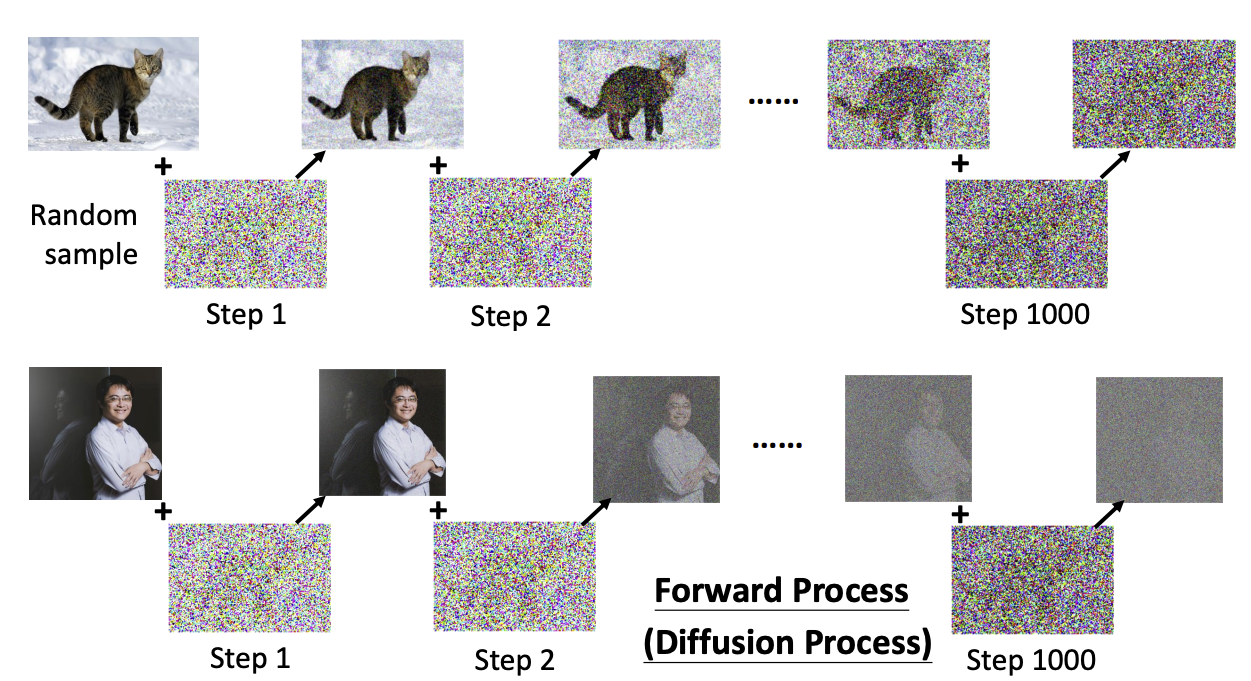

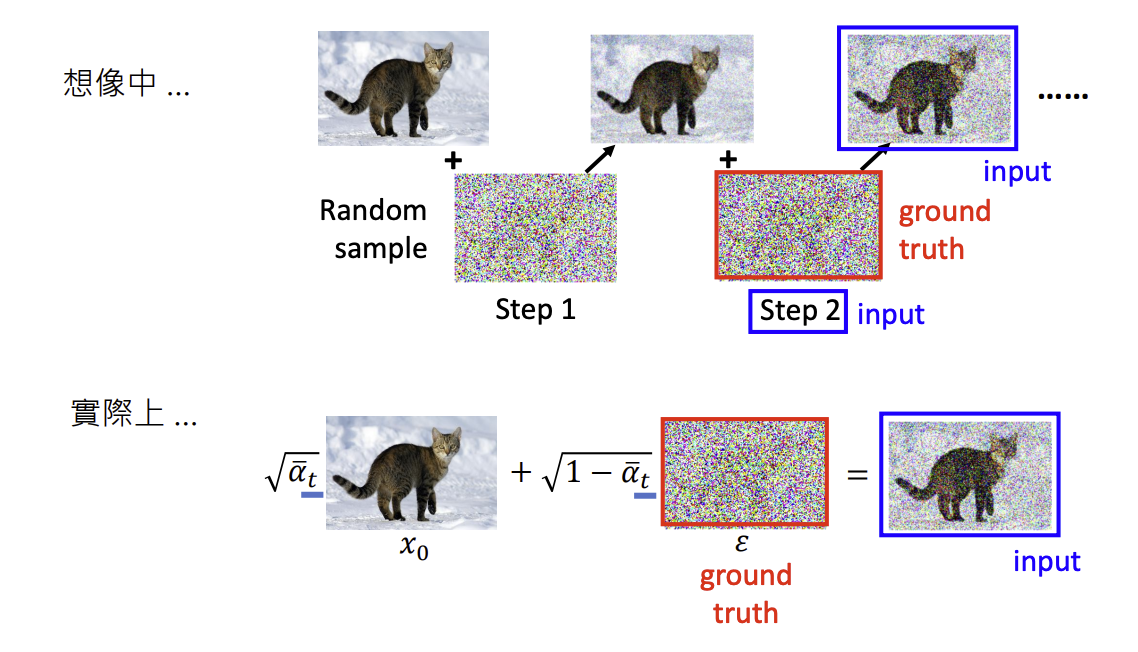

# Reverse Processing

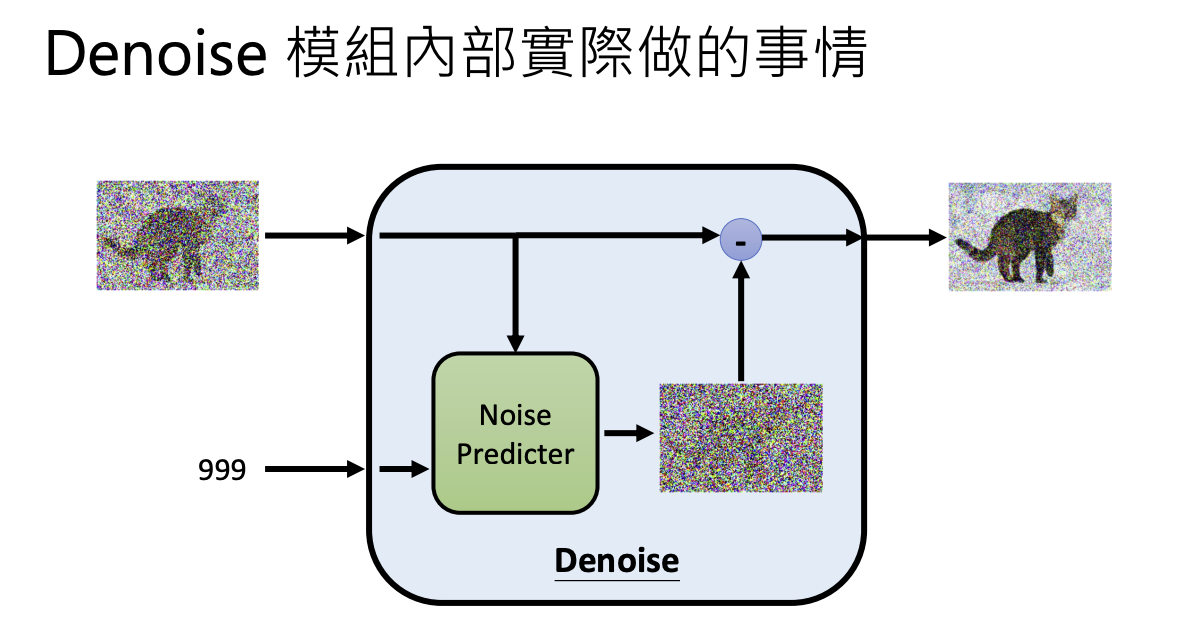

# Core Algorithm

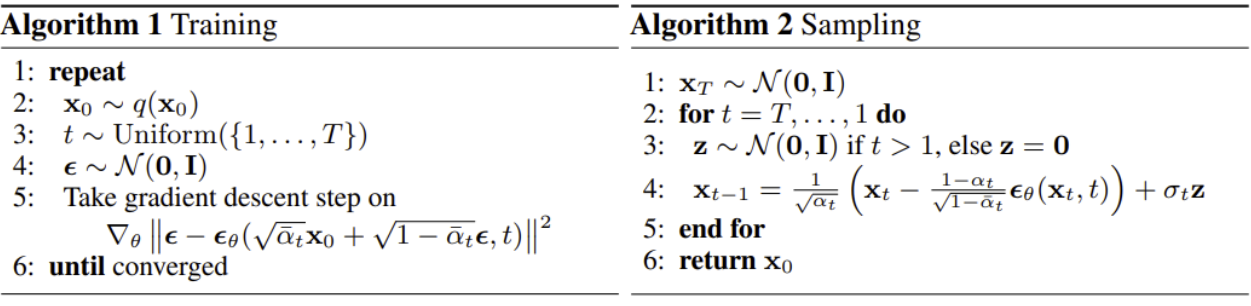

# Core Parts

In [120]:
class Diffusion:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, img_size=64,device="cuda"):
        self.device = device
        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta = self.gen_beta()
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.img_size = img_size

    def gen_beta(self):
        return torch.linspace(self.beta_start, self.beta_end,self.T)

    def gen_noise(self, x):
        return torch.randn_like(x)

    def forward_process(self, x, t):
        noise = self.gen_noise(x)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:,None,None,None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:,None,None,None]
        return sqrt_alpha_bar*x + sqrt_one_minus_alpha_bar*noise, noise

    def sampling(self, model, n):
        model.eval()
        x_t = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
        with torch.no_grad():
          for i in tqdm(reversed(range(1, self.T)), position=0):
              t = (torch.ones(n)*i).long().to(self.device)
              predicted_noise = model(x_t, t)
              self.alpha = self.alpha.to(self.device)
              self.beta = self.beta.to(self.device)
              self.alpha_bar = self.alpha_bar.to(self.device)
              alpha = self.alpha[t][:, None, None, None]
              alpha_bar = self.alpha_bar[t][:, None, None, None]
              beta = self.beta[t][:, None, None, None]
              if i > 1:
                    additional_noise = torch.randn_like(x_t)
              else:
                    additional_noise = torch.zeros_like(x_t)
              x_t = 1 / torch.sqrt(alpha) * (x_t - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise) + torch.sqrt(beta) * additional_noise
        x_t = (x_t.clamp(-1,1)+1) / 2
        x_t = (x_t*255).type(torch.uint8)
        return x_t




In [121]:
def load_image(image_path, image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Visualize Forward Process

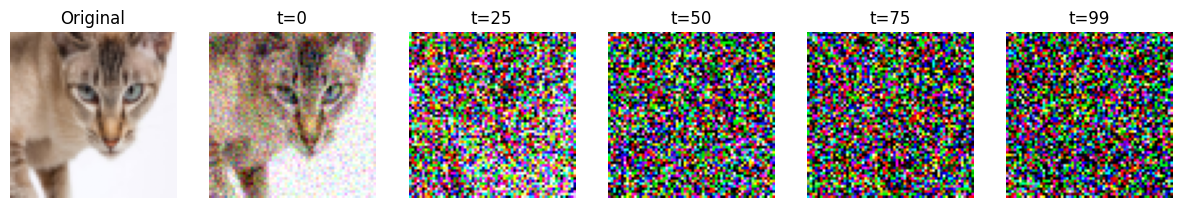

In [122]:
T = 100
beta_start = 0.01
beta_end = 0.2
diffusion = Diffusion(T, beta_start, beta_end, 64)

image_path = "cat.jpg"
image_size = 64
image = load_image(image_path, image_size).to(torch.float32)
steps = [0, T // 4, T // 2, 3 * T // 4, T - 1]
images = []
titles = []

for t in steps:
    t_tensor = torch.tensor([t]).long()
    x_t, _ = diffusion.forward_process(image, t_tensor)
    images.append(x_t.squeeze(0))
    titles.append(f"t={t}")
images.insert(0, image.squeeze(0))
titles.insert(0, "Original")
show_images(images, titles)

# Noise Predictor

In [123]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [124]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

<ipython-input-129-14c90772db51>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("unconditional_ckpt.pt")
999it [00:42, 23.28it/s]


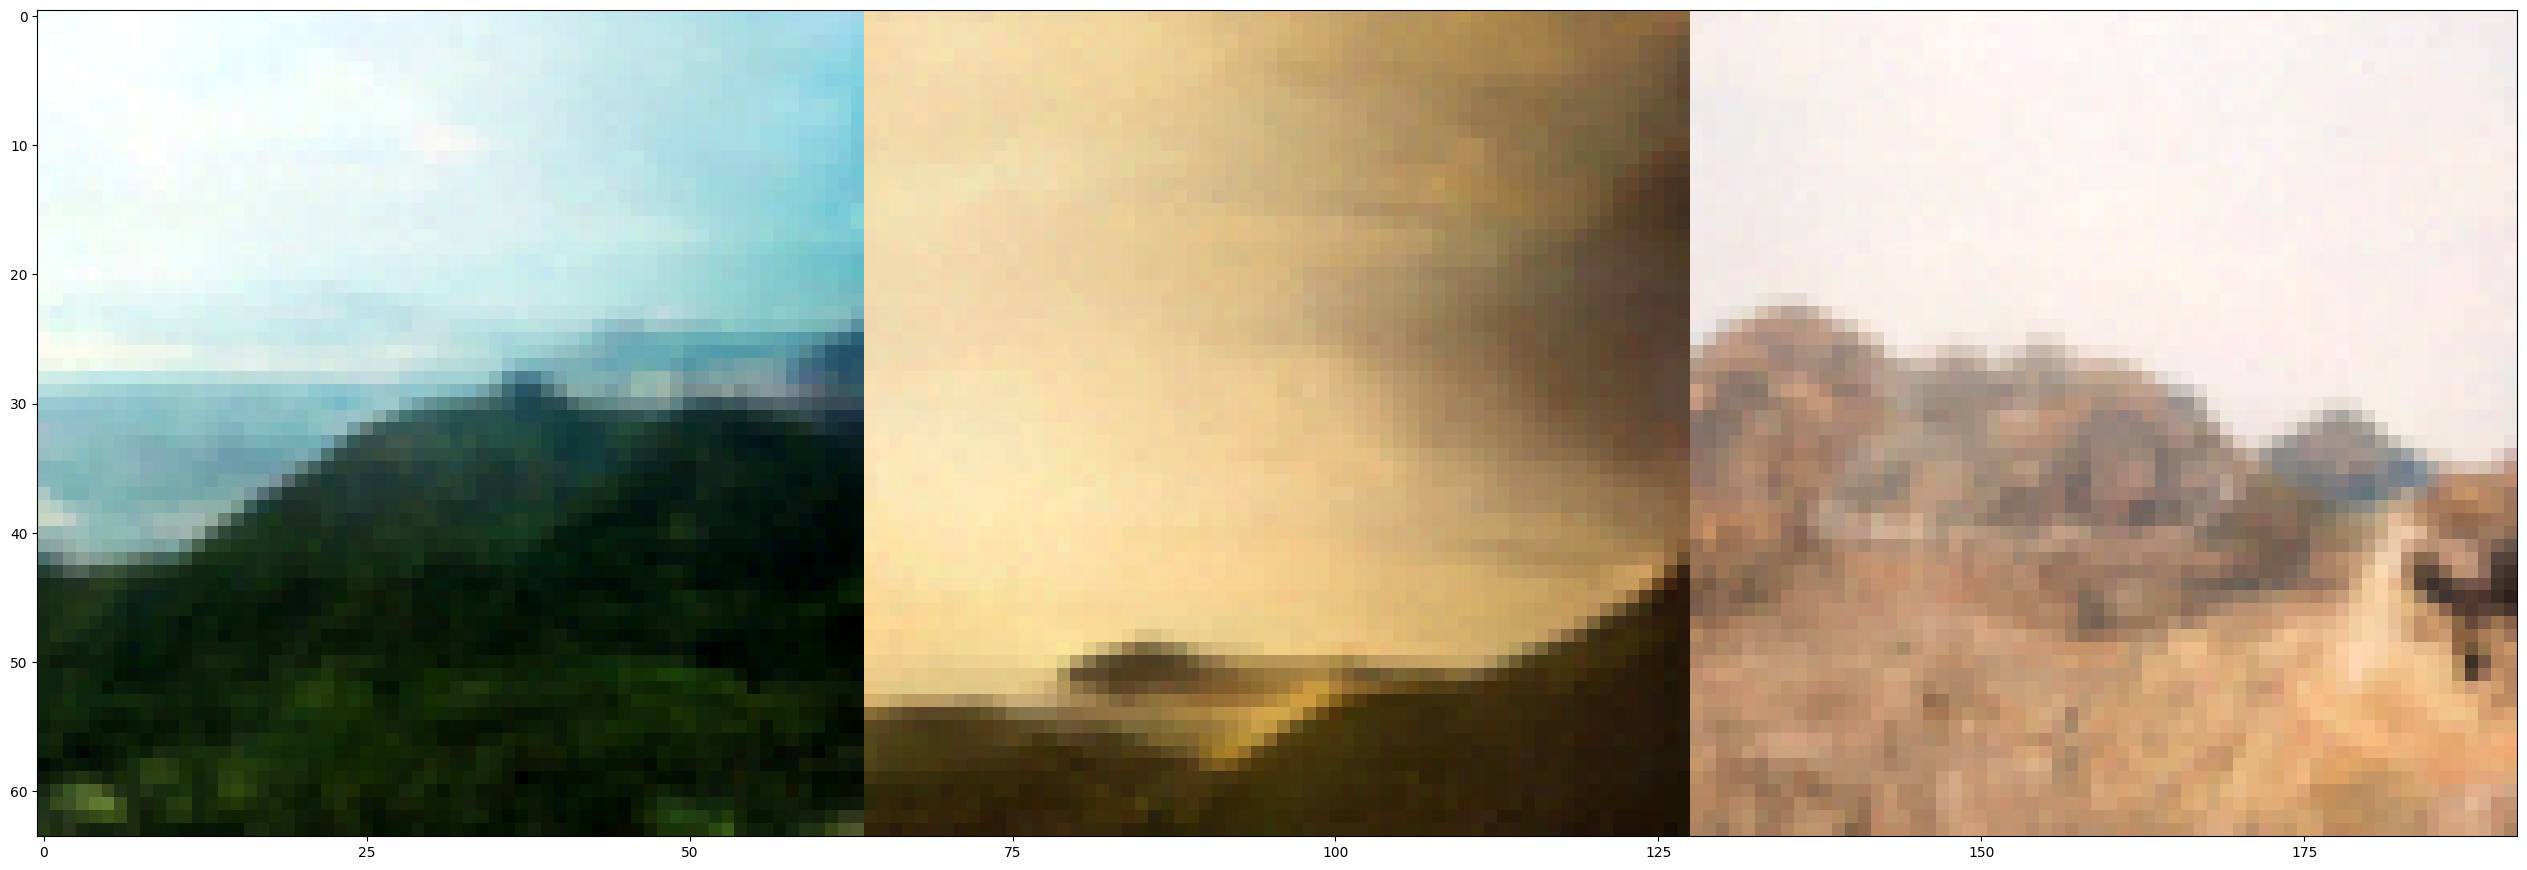

In [129]:
device = "cuda"
model = UNet().to(device)
ckpt = torch.load("unconditional_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(T=1000, img_size=64)
x = diffusion.sampling(model, n=3)
plot_images(x)